# Assessing local patterns of spatial heteroskedasticity

In the following notebook we review the local spatial heteroskedasticity (LOSH) statistic ($H_i$) put forward by [Ord and Getis (2012)](https://link.springer.com/article/10.1007/s00168-011-0492-y). LOSH is meant as an accompainment to the local statistics that analyze the mean level of a spatial process. LOSH focuses on analyzing the variance of the spatial process.

As outlined by Ord and Getis, consider a 10 x 10 grid of property values. Within this grid, there is a central high-rent district (identified by cells that are 1) and a surrounding lower-value area (identified by cells that are 0. We can visualize this spatial arrangement as:

|   |   |   |   |   |   |   |   |   |   |
|---|---|---|---|---|---|---|---|---|---|
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 1 | 1 | 1 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 1 | 1 | 1 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 1 | 1 | 1 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 1 | 1 | 1 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |

While we can see that the inner core of the high-rent district have similar values to their neigbhors (i.e. a cells of 1 surrounded by other cells of 1), this is less true when we consider the outer rim of the high-rent district. This rim represents a possible transition region between the stable inner high-rent area and the stable outer lower value areas. Ord and Getis seek to use the LOSH statistic ($H_i$) to identify this transitional region between the two areas.

# Understanding the LOSH statistic

Ord and Getis begin by defining a local mean,  $\bar{x}_i (d)$, as a re-scaled form of their $G^*_i$ statistic. This local mean is: 

Eq. 1 $$ \bar{x}_i (d) = \frac{\sum_j w_{ij} (d) x_j}{\sum_j w_{ij}(d)} $$

With a local mean defined, we can understand local residuals as the value of a local unit minus the local mean, or: 

Eq. 2 $$ e_j(d) = x_j - \bar{x}_i(d), j \in N(i,d) $$

These local residuals may be incorporated into Eq. 1 to form a final local dispersion statistic called $H_i$:

Eq. 3 $$H_i(d) = \frac{\sum w_{ij}(d) |e_j(d)|^a}{\sum w_{ij}(d)}$$

Note the addition of a new variable, $a$. This handles the interpretation of the residuals. As explaiend by Ord and Getis: 

>When a = 1, we have an absolute deviations measure, Hi 1, and when a = 2 a variance measure, Hi2. Clearly, other choices are possible, along with various robust forms to avoid outliers. In order to produce a standard measure, we should divide by the mean absolute deviation or variance for the whole data set.

The default settings of the `losh()` function set $a=2$.

# Interpreting the LOSH statistic

Ord and Getis suggest that the $H_i$ statistic may benefit from interpretation with the $G^*_i$ statistic. The logic of this combined interpretation is that a the $G^*_i$ value speaks to the local mean of the phenomenon of interest, whereas the $H_i$ speaks to the local heterogeneity. Ord and Getis provide the following table as a simplified guide for interpretation:

| Mean\variance     | High $H_i$                                                                    | Low $H_i$                                                                                                                      |
|-------------------|-------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------|
| Large $|G^*_i|$ | A hot spot with <br> heterogeneous local conditions                                | A hot spot with similar surrounding areas; <br> the map would indicate whether the <br> affected region is larger than the single 'cell' |
| Small $|G^*_i|$ | Heterogeneous local conditions but <br> at a low average level (an unlikely event) | Homogeneous local conditions <br> and a low average level                                                                           |
|                   |                                                                               |                                                                                                                                |

# Inference on the LOSH statistic

The current inference in the PySAL implementation of the LOSH statistic uses a $\chi^2$ distribution. For each unit, we calculate a Z-score as: 

$$ Z_i = 2H_i / V_i$$ with $2/V_i$ degrees of freedom. $V_i$ is the local variance of the unit, calculated as: 

$$ Var_{p}(H_i) = \frac{1}{n-1} \left( \frac{1}{h_1 W_{i1}}\right) ^2 (h_2 - h_1^2) \left[nW_{i2} - W_{i1}^2\right] $$

It is worthwhile to note that alternative methods for inference have been proposed in [Xu et al (2014).](https://ideas.repec.org/a/spr/anresc/v52y2014i3p697-710.html) While these methods are not yet implemented in PySAL, they are available in the `R` `spdep` package as `LOSH.mc`. The PySAL function is comparable to the `spdep` `LOSH` and `LOSH.cs` functions.

# Applying the LOSH statistic on a dataset

As a point of comparison, we now demonstrate the PySAL `losh` function on the [Boston Housing Dataset](https://geodacenter.github.io/data-and-lab//boston-housing/), which is also used as the docexample in `R` `spdep` `LOSH.cs`. We are interested in the variable `NOX`, which is the '...vector of nitric oxides concentration (parts per 10 million) per town'. 

We first load the `Bostonhsg` example dataset from `libpysal`:

In [1]:
import geopandas
import libpysal

boston = libpysal.examples.load_example("Bostonhsg")
boston_ds = geopandas.read_file(boston.get_path("boston.shp"))

Then we construct a Queen weight structure:

In [2]:
w = libpysal.weights.Queen.from_dataframe(boston_ds, use_index=False)

We can now import the `losh()` function. Note that it is in the form of a scikit-learn type estimator, so we pass both a series of arguments and then call `.fit()`.

In [3]:
from esda.losh import LOSH

ls = LOSH(connectivity=w, inference="chi-square").fit(boston_ds["NOX"])

We can now examine the LOSH ($H_i$) values and their significance.

In [4]:
ls.Hi[0:10]

array([0.19690679, 0.51765774, 0.80382881, 0.80854441, 0.530667  ,
       0.525579  , 0.83291425, 0.84215733, 0.48875154, 0.41955327])

In [5]:
ls.pval[0:10]

array([0.86292242, 0.61157688, 0.45697742, 0.34426167, 0.57934554,
       0.55430556, 0.4135546 , 0.40999792, 0.54025022, 0.57801529])

If we want to map the LOSH ($H_i$) values, we need to add them back to the `boston_ds` dataframe.

In [6]:
boston_ds["Hi"] = ls.Hi
boston_ds["Hi_pval"] = ls.pval

We can now map the LOSH ($H_i$) values. Note that we choose a Quantile break scheme here for visualization purposes.

<Axes: >

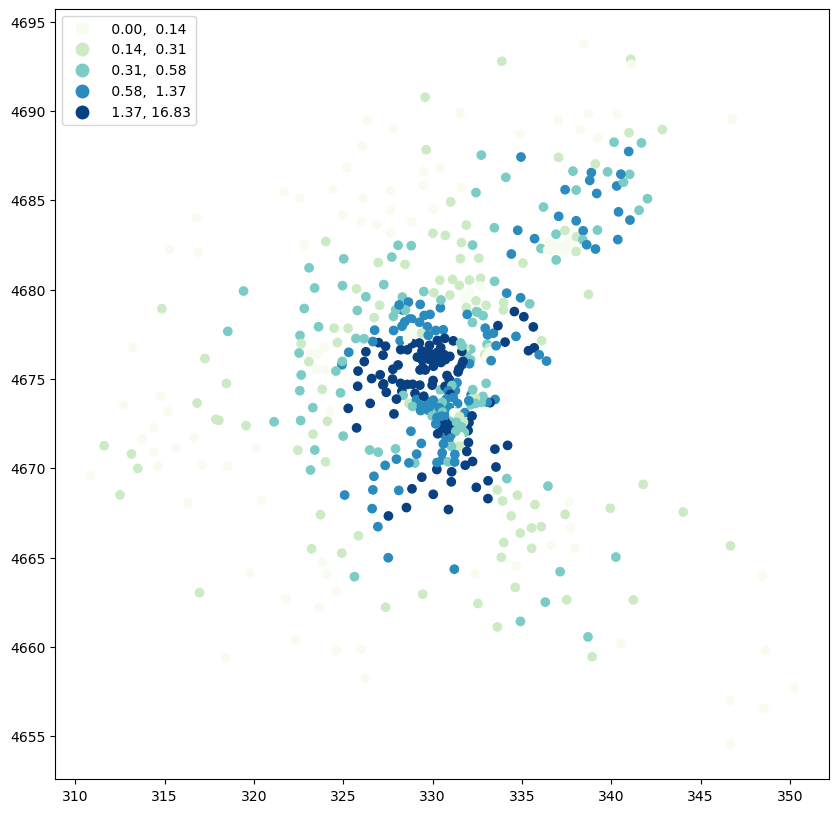

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={"aspect": "equal"})
boston_ds.plot(column="Hi", scheme="Quantiles", k=5, cmap="GnBu", legend=True, ax=ax)

We can also examine significance of the values. We use cutoffs of 0.01, 0.05, 0.10, and above 0.10.

<Axes: >

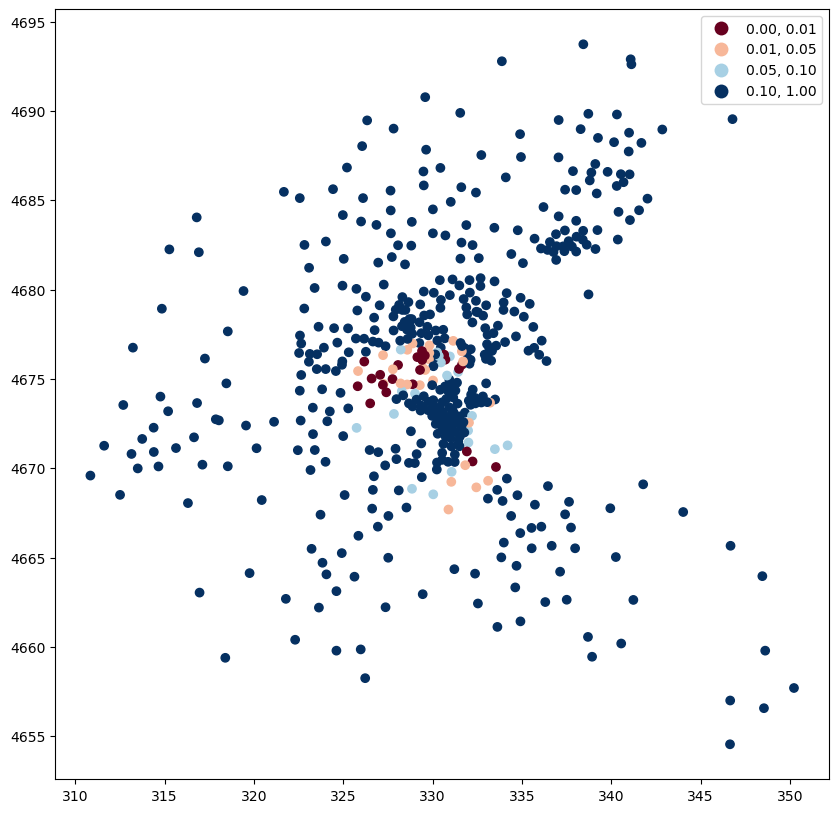

In [8]:
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={"aspect": "equal"})
boston_ds.plot(
    column="Hi_pval",
    cmap="RdBu",
    legend=True,
    ax=ax,
    scheme="user_defined",
    classification_kwds={"bins": [0.01, 0.05, 0.10, 1]},
)